# Capstone 2: Biodiversity Project

# Introduction
You are a biodiversity analyst working for the National Parks Service.  You're going to help them analyze some data about species at various national parks.

Note: The data that you'll be working with for this project is *inspired* by real data, but is mostly fictional.

# Step 1
Import the modules that you'll be using in this assignment:
- `from matplotlib import pyplot as plt`
- `import pandas as pd`

In [1]:
from matplotlib import pyplot as plt
import pandas as pd

# Step 2
You have been given two CSV files. `species_info.csv` with data about different species in our National Parks, including:
- The scientific name of each species
- The common names of each species
- The species conservation status

Load the dataset and inspect it:
- Load `species_info.csv` into a DataFrame called `species`

In [2]:
species = pd.read_csv('species_info.csv')

Inspect each DataFrame using `.head()`.

In [3]:
species.head()

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN


# Step 3
Let's start by learning a bit more about our data.  Answer each of the following questions.

How many different species are in the `species` DataFrame?

In [9]:
len(species)

5824

What are the different values of `category` in `species`?

In [10]:
species.describe()

,category,scientific_name,common_names,conservation_status
count,5824,5824,5824,191
unique,7,5541,5504,4
top,Vascular Plant,Holcus lanatus,Brachythecium Moss,Species of Concern
freq,4470,3,7,161


What are the different values of `conservation_status`?

In [6]:
species.conservation_status.unique()

array([nan, 'Species of Concern', 'Endangered', 'Threatened',
       'In Recovery'], dtype=object)

# Step 4
Let's start doing some analysis!

The column `conservation_status` has several possible values:
- `Species of Concern`: declining or appear to be in need of conservation
- `Threatened`: vulnerable to endangerment in the near future
- `Endangered`: seriously at risk of extinction
- `In Recovery`: formerly `Endangered`, but currnetly neither in danger of extinction throughout all or a significant portion of its range

We'd like to count up how many species meet each of these criteria.  Use `groupby` to count how many `scientific_name` meet each of these criteria.

In [7]:
species.groupby('conservation_status')['scientific_name'].count()

conservation_status
Endangered             16
In Recovery             4
Species of Concern    161
Threatened             10
Name: scientific_name, dtype: int64

As we saw before, there are far more than 200 species in the `species` table.  Clearly, only a small number of them are categorized as needing some sort of protection.  The rest have `conservation_status` equal to `None`.  Because `groupby` does not include `None`, we will need to fill in the null values.  We can do this using `.fillna`.  We pass in however we want to fill in our `None` values as an argument.

Paste the following code and run it to see replace `None` with `No Intervention`:
```python
species.fillna('No Intervention', inplace=True)
```

In [11]:
species.fillna('No Intervention', inplace=True)

Great! Now run the same `groupby` as before to see how many species require `No Intervention`.

In [12]:
species.groupby('conservation_status')['scientific_name'].count()

conservation_status
Endangered              16
In Recovery              4
No Intervention       5633
Species of Concern     161
Threatened              10
Name: scientific_name, dtype: int64

Let's use `plt.bar` to create a bar chart.  First, let's sort the columns by how many species are in each categories.  We can do this using `.sort_values`.  We use the the keyword `by` to indicate which column we want to sort by.

Paste the following code and run it to create a new DataFrame called `protection_counts`, which is sorted by `scientific_name`:
```python
protection_counts = species.groupby('conservation_status')\
    .scientific_name.nunique().reset_index()\
    .sort_values(by='scientific_name')
```

In [19]:
protection_counts = species.groupby('conservation_status')\
    .scientific_name.nunique().reset_index()\
    .sort_values(by='scientific_name')

protection_counts.head()

,conservation_status,scientific_name
1,In Recovery,4
4,Threatened,10
0,Endangered,15
3,Species of Concern,151
2,No Intervention,5363


Now let's create a bar chart!
1. Start by creating a wide figure with `figsize=(10, 4)`
1. Start by creating an axes object called `ax` using `plt.subplot`.
2. Create a bar chart whose heights are equal to `scientific_name` column of `protection_counts`.
3. Create an x-tick for each of the bars.
4. Label each x-tick with the label from `conservation_status` in `protection_counts`
5. Label the y-axis `Number of Species`
6. Title the graph `Conservation Status by Species`
7. Plot the grap using `plt.show()`

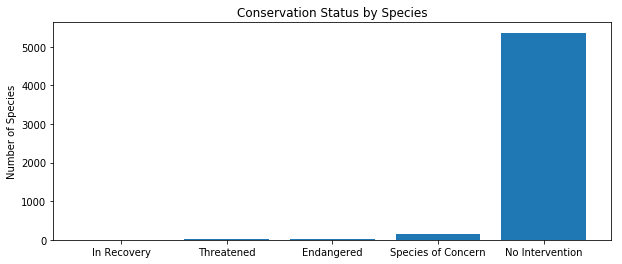

In [24]:
plt.figure(figsize=(10, 4))
ax = plt.subplot()

plt.bar(range(len(protection_counts)), protection_counts['scientific_name'])
ax.set_xticks(range(len(protection_counts)))
ax.set_xticklabels(protection_counts.conservation_status.values)
plt.ylabel('Number of Species')
plt.title('Conservation Status by Species')
plt.show()

# Step 4
Are certain types of species more likely to be endangered?

Let's create a new column in `species` called `is_protected`, which is `True` if `conservation_status` is not equal to `No Intervention`, and `False` otherwise.

In [61]:
species['is_protected'] = species.conservation_status != 'No Intervention'

Let's group the `species` data frame by the `category` and `is_protected` columns and count the unique `scientific_name`s in each grouping.

Save your results to `category_counts`.

In [62]:
category_counts1 = species.groupby(['category','is_protected'])['scientific_name'].count()
category_counts1

category           is_protected
Amphibian          False             73
                   True               7
Bird               False            442
                   True              79
Fish               False            116
                   True              11
Mammal             False            176
                   True              38
Nonvascular Plant  False            328
                   True               5
Reptile            False             74
                   True               5
Vascular Plant     False           4424
                   True              46
Name: scientific_name, dtype: int64

Examine `category_counts` using `head()`.

In [63]:
category_counts = species.groupby(['category', 'is_protected'])\
                         .scientific_name.nunique().reset_index()
category_counts

,category,is_protected,scientific_name
0,Amphibian,False,72
1,Amphibian,True,7
2,Bird,False,413
3,Bird,True,75
4,Fish,False,115
5,Fish,True,11
6,Mammal,False,146
7,Mammal,True,30
8,Nonvascular Plant,False,328
9,Nonvascular Plant,True,5


It's going to be easier to view this data if we pivot it.  Using `pivot`, rearange `category_counts` so that:
- `columns` is `is_protected`
- `index` is `category`
- `values` is `scientific_name`

Save your pivoted data to `category_pivot`. Remember to `reset_index()` at the end.

In [64]:
category_pivot = category_counts.pivot(index='category', values='scientific_name', columns='is_protected').reset_index()

Examine `category_pivot`.

In [65]:
category_pivot

is_protected,category,False,True
0,Amphibian,72,7
1,Bird,413,75
2,Fish,115,11
3,Mammal,146,30
4,Nonvascular Plant,328,5
5,Reptile,73,5
6,Vascular Plant,4216,46


Use the `.columns` property to  rename the categories `True` and `False` to something more description:
- Leave `category` as `category`
- Rename `False` to `not_protected`
- Rename `True` to `protected`

In [67]:
category_pivot.columns = ['category', 'not_protected', 'protected']

Let's create a new column of `category_pivot` called `percent_protected`, which is equal to `protected` (the number of species that are protected) divided by `protected` plus `not_protected` (the total number of species).

In [68]:
category_pivot['percent_protected'] = category_pivot['protected'] / (category_pivot['protected'] + category_pivot['not_protected'])

Examine `category_pivot`.

In [69]:
category_pivot

,category,not_protected,protected,percent_protected
0,Amphibian,72,7,0.088608
1,Bird,413,75,0.153689
2,Fish,115,11,0.087302
3,Mammal,146,30,0.170455
4,Nonvascular Plant,328,5,0.015015
5,Reptile,73,5,0.064103
6,Vascular Plant,4216,46,0.010793


It looks like species in category `Mammal` are more likely to be endangered than species in `Bird`.  We're going to do a significance test to see if this statement is true.  Before you do the significance test, consider the following questions:
- Is the data numerical or categorical?
- How many pieces of data are you comparing?

Based on those answers, you should choose to do a *chi squared test*.  In order to run a chi squared test, we'll need to create a contingency table.  Our contingency table should look like this:

||protected|not protected|
|-|-|-|
|Mammal|?|?|
|Bird|?|?|

Create a table called `contingency` and fill it in with the correct numbers

In [70]:
contingency = [[30, 146],
              [75, 413]]

In order to perform our chi square test, we'll need to import the correct function from scipy.  Past the following code and run it:
```py
from scipy.stats import chi2_contingency
```

In [71]:
from scipy.stats import chi2_contingency

Now run `chi2_contingency` with `contingency`.

In [72]:
chi2_contingency(contingency)

(0.1617014831654557, 0.6875948096661336, 1, array([[ 27.8313253, 148.1686747],
        [ 77.1686747, 410.8313253]]))

It looks like this difference isn't significant!

Let's test another.  Is the difference between `Reptile` and `Mammal` significant?

In [75]:
contingency2 = [[30, 146],
              [5, 73]]
chi2_contingency(contingency2)

(4.289183096203645, 0.03835559022969898, 1, array([[ 24.2519685, 151.7480315],
        [ 10.7480315,  67.2519685]]))

Yes! It looks like there is a significant difference between `Reptile` and `Mammal`!

# Step 5

Conservationists have been recording sightings of different species at several national parks for the past 7 days.  They've saved sent you their observations in a file called `observations.csv`.  Load `observations.csv` into a variable called `observations`, then use `head` to view the data.

In [77]:
observations = pd.read_csv('observations.csv')
observations.head()

,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


Some scientists are studying the number of sheep sightings at different national parks.  There are several different scientific names for different types of sheep.  We'd like to know which rows of `species` are referring to sheep.  Notice that the following code will tell us whether or not a word occurs in a string:

In [78]:
# Does "Sheep" occur in this string?
str1 = 'This string contains Sheep'
'Sheep' in str1

True

In [79]:
# Does "Sheep" occur in this string?
str2 = 'This string contains Cows'
'Sheep' in str2

False

Use `apply` and a `lambda` function to create a new column in `species` called `is_sheep` which is `True` if the `common_names` contains `'Sheep'`, and `False` otherwise.

In [85]:
species['is_sheep'] = species.common_names.apply(lambda x: 'Sheep' in x)

species.head()

,category,scientific_name,common_names,conservation_status,is_protected,is_sheep
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,No Intervention,False,False
1,Mammal,Bos bison,"American Bison, Bison",No Intervention,False,False
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",No Intervention,False,False
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",No Intervention,False,True
4,Mammal,Cervus elaphus,Wapiti Or Elk,No Intervention,False,False


Select the rows of `species` where `is_sheep` is `True` and examine the results.

In [86]:
species[species.is_sheep]

,category,scientific_name,common_names,conservation_status,is_protected,is_sheep
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",No Intervention,False,True
1139,Vascular Plant,Rumex acetosella,"Sheep Sorrel, Sheep Sorrell",No Intervention,False,True
2233,Vascular Plant,Festuca filiformis,Fineleaf Sheep Fescue,No Intervention,False,True
3014,Mammal,Ovis canadensis,"Bighorn Sheep, Bighorn Sheep",Species of Concern,True,True
3758,Vascular Plant,Rumex acetosella,"Common Sheep Sorrel, Field Sorrel, Red Sorrel,...",No Intervention,False,True
3761,Vascular Plant,Rumex paucifolius,"Alpine Sheep Sorrel, Fewleaved Dock, Meadow Dock",No Intervention,False,True
4091,Vascular Plant,Carex illota,"Sheep Sedge, Smallhead Sedge",No Intervention,False,True
4383,Vascular Plant,Potentilla ovina var. ovina,Sheep Cinquefoil,No Intervention,False,True
4446,Mammal,Ovis canadensis sierrae,Sierra Nevada Bighorn Sheep,Endangered,True,True


Many of the results are actually plants.  Select the rows of `species` where `is_sheep` is `True` and `category` is `Mammal`.  Save the results to the variable `sheep_species`.

In [87]:
sheep_species = species[(species.is_sheep) & (species.category == 'Mammal')]

Now merge `sheep_species` with `observations` to get a DataFrame with observations of sheep.  Save this DataFrame as `sheep_observations`.

In [88]:
sheep_observations = observations.merge(sheep_species)
sheep_observations

,scientific_name,park_name,observations,category,common_names,conservation_status,is_protected,is_sheep
0,Ovis canadensis,Yellowstone National Park,219,Mammal,"Bighorn Sheep, Bighorn Sheep",Species of Concern,True,True
1,Ovis canadensis,Bryce National Park,109,Mammal,"Bighorn Sheep, Bighorn Sheep",Species of Concern,True,True
2,Ovis canadensis,Yosemite National Park,117,Mammal,"Bighorn Sheep, Bighorn Sheep",Species of Concern,True,True
3,Ovis canadensis,Great Smoky Mountains National Park,48,Mammal,"Bighorn Sheep, Bighorn Sheep",Species of Concern,True,True
4,Ovis canadensis sierrae,Yellowstone National Park,67,Mammal,Sierra Nevada Bighorn Sheep,Endangered,True,True
5,Ovis canadensis sierrae,Yosemite National Park,39,Mammal,Sierra Nevada Bighorn Sheep,Endangered,True,True
6,Ovis canadensis sierrae,Bryce National Park,22,Mammal,Sierra Nevada Bighorn Sheep,Endangered,True,True
7,Ovis canadensis sierrae,Great Smoky Mountains National Park,25,Mammal,Sierra Nevada Bighorn Sheep,Endangered,True,True
8,Ovis aries,Yosemite National Park,126,Mammal,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",No Intervention,False,True
9,Ovis aries,Great Smoky Mountains National Park,76,Mammal,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",No Intervention,False,True


How many total sheep observations (across all three species) were made at each national park?  Use `groupby` to get the `sum` of `observations` for each `park_name`.  Save your answer to `obs_by_park`.

This is the total number of sheep observed in each park over the past 7 days.

In [91]:
obs_by_park = sheep_observations.groupby('park_name')['observations'].sum().reset_index()
obs_by_park

,park_name,observations
0,Bryce National Park,250
1,Great Smoky Mountains National Park,149
2,Yellowstone National Park,507
3,Yosemite National Park,282


Create a bar chart showing the different number of observations per week at each park.

1. Start by creating a wide figure with `figsize=(16, 4)`
1. Start by creating an axes object called `ax` using `plt.subplot`.
2. Create a bar chart whose heights are equal to `observations` column of `obs_by_park`.
3. Create an x-tick for each of the bars.
4. Label each x-tick with the label from `park_name` in `obs_by_park`
5. Label the y-axis `Number of Observations`
6. Title the graph `Observations of Sheep per Week`
7. Plot the grap using `plt.show()`

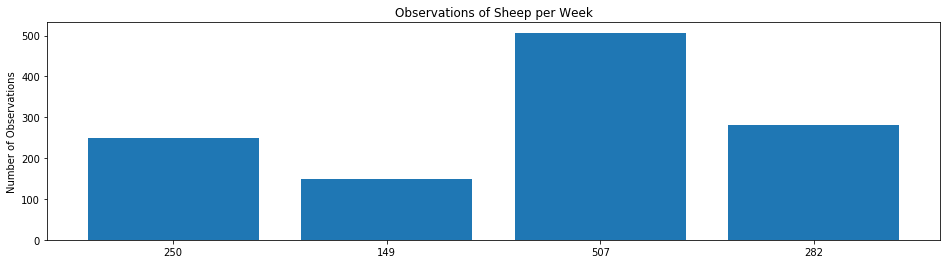

In [92]:
plt.figure(figsize=(16, 4))
ax = plt.subplot()

plt.bar(range(len(obs_by_park)), obs_by_park['observations'])
ax.set_xticks(range(len(obs_by_park)))
ax.set_xticklabels(obs_by_park['observations'].values)
plt.ylabel('Number of Observations')
plt.title('Observations of Sheep per Week')
plt.show()

Our scientists know that 15% of sheep at Bryce National Park have foot and mouth disease.  Park rangers at Yellowstone National Park have been running a program to reduce the rate of foot and mouth disease at that park.  The scientists want to test whether or not this program is working.  They want to be able to detect reductions of at least 5 percentage points.  For instance, if 10% of sheep in Yellowstone have foot and mouth disease, they'd like to be able to know this, with confidence.

Use <a href="https://s3.amazonaws.com/codecademy-content/courses/learn-hypothesis-testing/a_b_sample_size/index.html">Codecademy's sample size calculator</a> to calculate the number of sheep that they would need to observe from each park.  Use the default level of significance (90%).

Remember that "Minimum Detectable Effect" is a percent of the baseline.

In [ ]:
minimum_detectable_effect = 100 * 0.05 / 0.15
baseline = 15
sample_size_per_variant = 870

How many weeks would you need to observe sheep at Bryce National Park in order to observe enough sheep?  How many weeks would you need to observe at Yellowstone National Park to observe enough sheep?

In [5]:
bryce = 870 / 250
yellowstone = 810 / 507
print('It takes approximately',round(bryce,2),'weeks to observe sheep at Bryce National Park')
print('It takes approximately',round(yellowstone,2),'weeks to observe sheep at Yellowstone National Park')

It takes approximately 3.48 weeks to observe sheep at Bryce National Park
It takes approximately 1.6 weeks to observe sheep at Yellowstone National Park
